# Proxmox VM Monitoring Visualization

This notebook visualizes the performance metrics collected during glacier monitoring processing.
It shows CPU, memory, network I/O, and disk I/O over time to help identify bottlenecks.

In [1]:
import json
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import datetime
import numpy as np

# Set style for better plots
plt.style.use('dark_background')
plt.rcParams['figure.figsize'] = [14, 6]
plt.rcParams['figure.dpi'] = 100

In [ ]:
# Load the Proxmox monitoring data
DATA_FILE = 'proxmox_data.json'  # Change this to your file path

with open(DATA_FILE, 'r') as f:
    data = json.load(f)

# Convert samples to DataFrame
samples = pd.DataFrame(data['samples'])
samples['datetime'] = pd.to_datetime(samples['time_iso'])
samples['elapsed_seconds'] = samples['time'] - samples['time'].iloc[0]

# Calculate memory in GB
samples['mem_gb'] = samples['mem'] / (1024**3)
samples['maxmem_gb'] = samples['maxmem'] / (1024**3)

# Add memory stats in GB to data dict for later use
data['memory_stats']['min_gb'] = samples['mem_gb'].min()
data['memory_stats']['max_gb'] = samples['mem_gb'].max()
data['memory_stats']['avg_gb'] = samples['mem_gb'].mean()
data['memory_stats']['total_gb'] = samples['maxmem_gb'].iloc[0]

print(f"Monitoring Period: {data['monitoring_period']['duration_formatted']}")
print(f"Samples Collected: {data['samples_collected']}")
print(f"Events Recorded: {data['events_recorded']}")
print(f"\nTime Range: {samples['datetime'].iloc[0]} to {samples['datetime'].iloc[-1]}")
print(f"Total VM Memory: {data['memory_stats']['total_gb']:.2f} GB")

Monitoring Period: 3m 40s
Samples Collected: 211
Events Recorded: 4

Time Range: 2026-01-30 16:46:56.522219 to 2026-01-30 16:50:36.606282


In [ ]:
# Display summary statistics
print("=" * 60)
print("SUMMARY STATISTICS")
print("=" * 60)

print(f"\n📊 CPU Usage:")
print(f"   Min: {data['cpu_stats']['min_percent']:.2f}%")
print(f"   Max: {data['cpu_stats']['max_percent']:.2f}%")
print(f"   Avg: {data['cpu_stats']['avg_percent']:.2f}%")

print(f"\n💾 Memory Usage (Total: {data['memory_stats']['total_gb']:.2f} GB):")
print(f"   Min: {data['memory_stats']['min_gb']:.2f} GB")
print(f"   Max: {data['memory_stats']['max_gb']:.2f} GB")
print(f"   Avg: {data['memory_stats']['avg_gb']:.2f} GB")

print(f"\n🌐 Network Transfer:")
print(f"   Downloaded: {data['network_transfer']['mb_in']:.2f} MB")
print(f"   Uploaded: {data['network_transfer']['mb_out']:.2f} MB")
print(f"   Avg Download Speed: {data['network_transfer']['avg_speed_mbps_in']:.2f} Mbps")
print(f"   Avg Upload Speed: {data['network_transfer']['avg_speed_mbps_out']:.2f} Mbps")

print(f"\n💿 Disk I/O:")
print(f"   Read: {data['disk_io']['mb_read']:.2f} MB")
print(f"   Written: {data['disk_io']['mb_written']:.2f} MB")

SUMMARY STATISTICS

📊 CPU Usage:
   Min: 0.96%
   Max: 30.29%
   Avg: 17.16%

💾 Memory Usage:
   Min: 6.98%
   Max: 11.12%
   Avg: 9.19%

🌐 Network Transfer:
   Downloaded: 1397.24 MB
   Uploaded: 29.20 MB
   Avg Download Speed: 53.22 Mbps
   Avg Upload Speed: 1.11 Mbps

💿 Disk I/O:
   Read: 0.00 MB
   Written: 30.13 MB


In [4]:
# Calculate network transfer rate (bytes per second)
samples['netin_rate'] = samples['netin'].diff() / samples['time'].diff()
samples['netout_rate'] = samples['netout'].diff() / samples['time'].diff()

# Convert to Mbps
samples['netin_mbps'] = samples['netin_rate'] * 8 / 1e6
samples['netout_mbps'] = samples['netout_rate'] * 8 / 1e6

# Calculate disk I/O rate
samples['diskread_rate'] = samples['diskread'].diff() / samples['time'].diff() / 1e6  # MB/s
samples['diskwrite_rate'] = samples['diskwrite'].diff() / samples['time'].diff() / 1e6  # MB/s

# Fill NaN values
samples = samples.fillna(0)

## CPU and Memory Usage Over Time

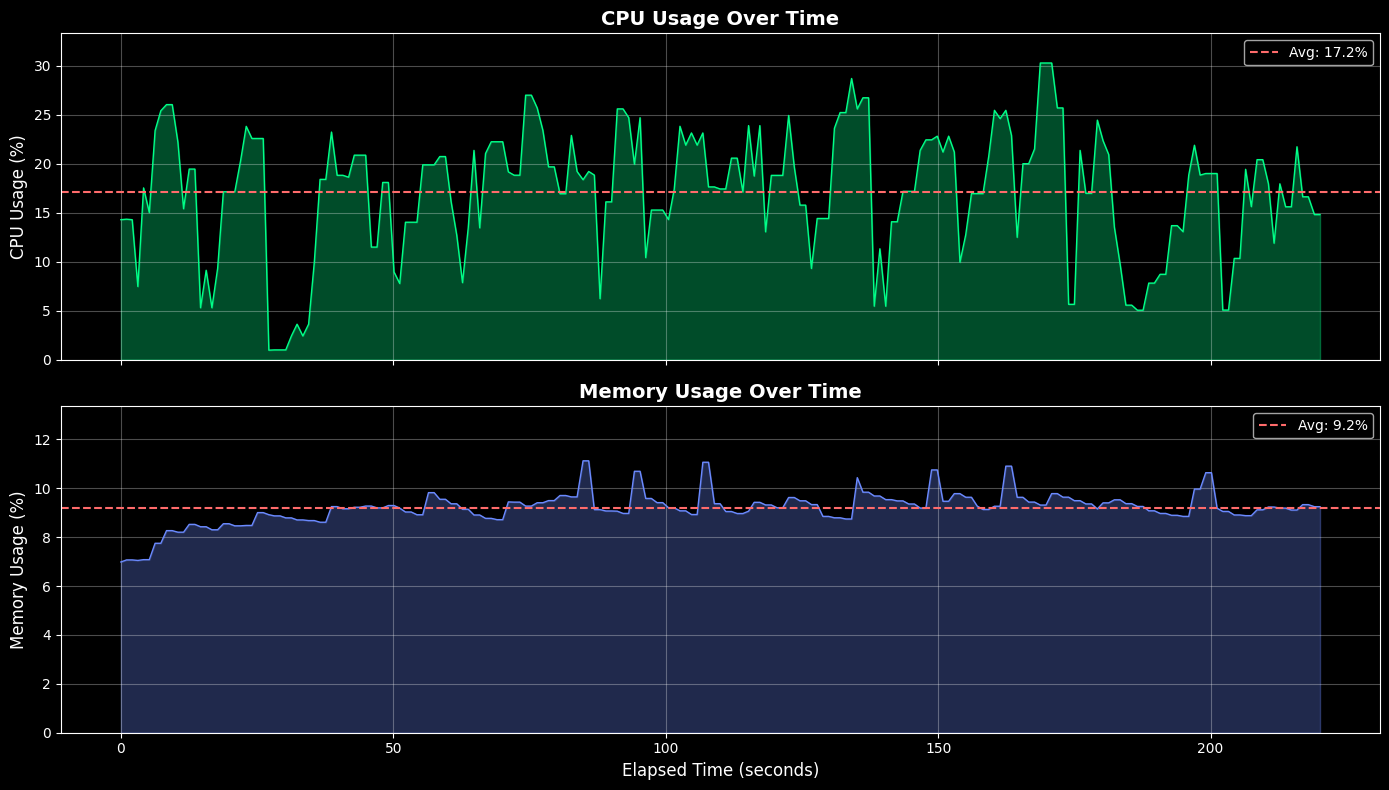

In [ ]:
fig, axes = plt.subplots(2, 1, figsize=(14, 8), sharex=True)

# CPU Usage
ax1 = axes[0]
ax1.fill_between(samples['elapsed_seconds'], samples['cpu_percent'], alpha=0.3, color='#00ff88')
ax1.plot(samples['elapsed_seconds'], samples['cpu_percent'], color='#00ff88', linewidth=1)
ax1.axhline(y=data['cpu_stats']['avg_percent'], color='#ff6b6b', linestyle='--', label=f"Avg: {data['cpu_stats']['avg_percent']:.1f}%")
ax1.set_ylabel('CPU Usage (%)', fontsize=12)
ax1.set_title('CPU Usage Over Time', fontsize=14, fontweight='bold')
ax1.legend(loc='upper right')
ax1.set_ylim(0, max(samples['cpu_percent']) * 1.1)
ax1.grid(True, alpha=0.3)

# Memory Usage in GB
ax2 = axes[1]
ax2.fill_between(samples['elapsed_seconds'], samples['mem_gb'], alpha=0.3, color='#6b8aff')
ax2.plot(samples['elapsed_seconds'], samples['mem_gb'], color='#6b8aff', linewidth=1)
ax2.axhline(y=data['memory_stats']['avg_gb'], color='#ff6b6b', linestyle='--', label=f"Avg: {data['memory_stats']['avg_gb']:.2f} GB")
ax2.axhline(y=data['memory_stats']['total_gb'], color='#ffaa00', linestyle=':', alpha=0.5, label=f"Total: {data['memory_stats']['total_gb']:.1f} GB")
ax2.set_ylabel('Memory Usage (GB)', fontsize=12)
ax2.set_xlabel('Elapsed Time (seconds)', fontsize=12)
ax2.set_title('Memory Usage Over Time', fontsize=14, fontweight='bold')
ax2.legend(loc='upper right')
ax2.set_ylim(0, data['memory_stats']['total_gb'] * 1.1)
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## Network Traffic Over Time

This shows the network download/upload speed. High spikes indicate data being fetched from the STAC/Zarr servers.

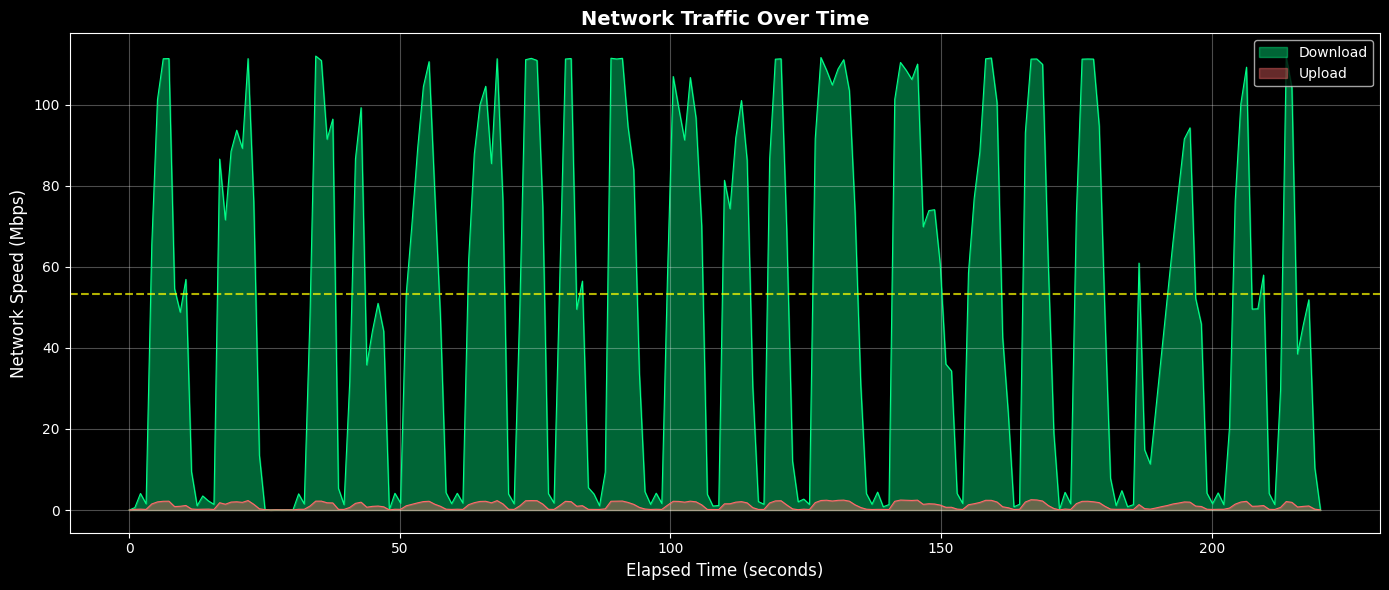


📈 Network Analysis:
   Peak Download: 111.97 Mbps
   Average Download: 52.81 Mbps
   Total Downloaded: 1397.24 MB


In [6]:
fig, ax = plt.subplots(figsize=(14, 6))

# Network In (Download)
ax.fill_between(samples['elapsed_seconds'], samples['netin_mbps'], alpha=0.4, color='#00ff88', label='Download')
ax.plot(samples['elapsed_seconds'], samples['netin_mbps'], color='#00ff88', linewidth=0.8)

# Network Out (Upload) - typically much smaller
ax.fill_between(samples['elapsed_seconds'], samples['netout_mbps'], alpha=0.4, color='#ff6b6b', label='Upload')
ax.plot(samples['elapsed_seconds'], samples['netout_mbps'], color='#ff6b6b', linewidth=0.8)

ax.set_ylabel('Network Speed (Mbps)', fontsize=12)
ax.set_xlabel('Elapsed Time (seconds)', fontsize=12)
ax.set_title('Network Traffic Over Time', fontsize=14, fontweight='bold')
ax.legend(loc='upper right')
ax.grid(True, alpha=0.3)

# Add average line
avg_download = data['network_transfer']['avg_speed_mbps_in']
ax.axhline(y=avg_download, color='yellow', linestyle='--', alpha=0.7, label=f"Avg Download: {avg_download:.1f} Mbps")

plt.tight_layout()
plt.show()

print(f"\n📈 Network Analysis:")
print(f"   Peak Download: {samples['netin_mbps'].max():.2f} Mbps")
print(f"   Average Download: {samples['netin_mbps'].mean():.2f} Mbps")
print(f"   Total Downloaded: {data['network_transfer']['mb_in']:.2f} MB")

## Cumulative Network Transfer

Shows the total data transferred over time - useful for seeing data fetch patterns.

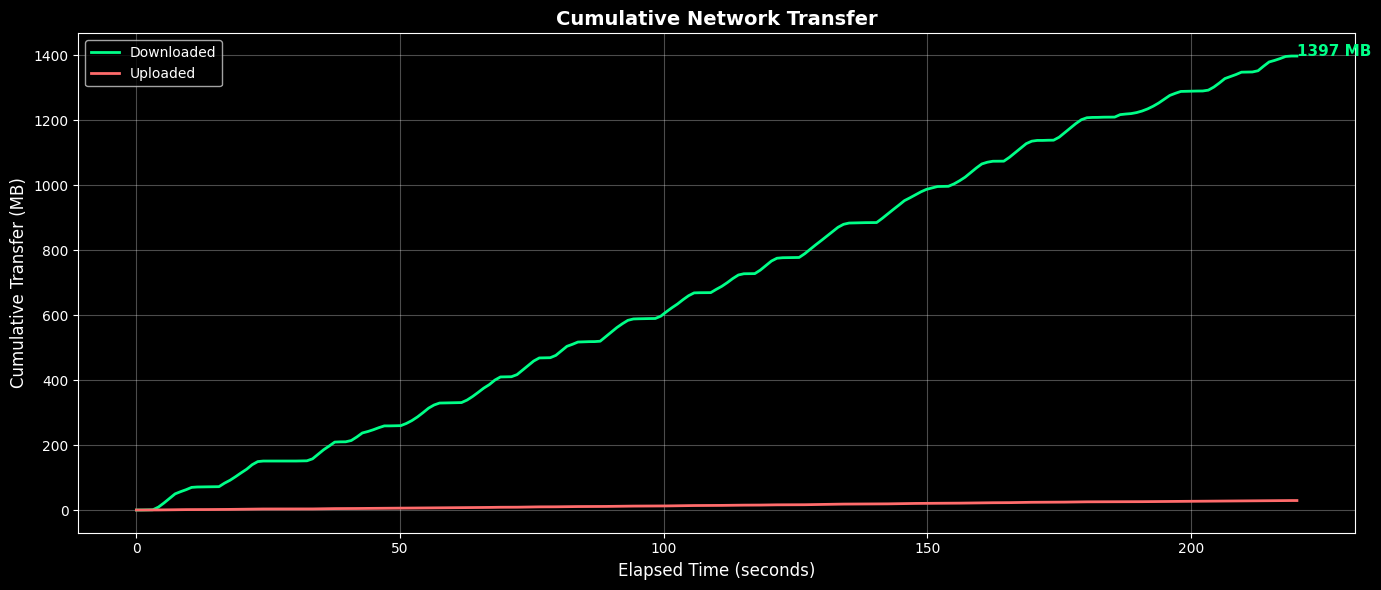

In [7]:
# Calculate cumulative transfer from start
samples['cumulative_in_mb'] = (samples['netin'] - samples['netin'].iloc[0]) / (1024 * 1024)
samples['cumulative_out_mb'] = (samples['netout'] - samples['netout'].iloc[0]) / (1024 * 1024)

fig, ax = plt.subplots(figsize=(14, 6))

ax.plot(samples['elapsed_seconds'], samples['cumulative_in_mb'], color='#00ff88', linewidth=2, label='Downloaded')
ax.plot(samples['elapsed_seconds'], samples['cumulative_out_mb'], color='#ff6b6b', linewidth=2, label='Uploaded')

ax.set_ylabel('Cumulative Transfer (MB)', fontsize=12)
ax.set_xlabel('Elapsed Time (seconds)', fontsize=12)
ax.set_title('Cumulative Network Transfer', fontsize=14, fontweight='bold')
ax.legend(loc='upper left')
ax.grid(True, alpha=0.3)

# Annotate final values
final_in = samples['cumulative_in_mb'].iloc[-1]
final_out = samples['cumulative_out_mb'].iloc[-1]
ax.annotate(f'{final_in:.0f} MB', xy=(samples['elapsed_seconds'].iloc[-1], final_in), 
            fontsize=11, color='#00ff88', fontweight='bold')

plt.tight_layout()
plt.show()

## Disk I/O Over Time

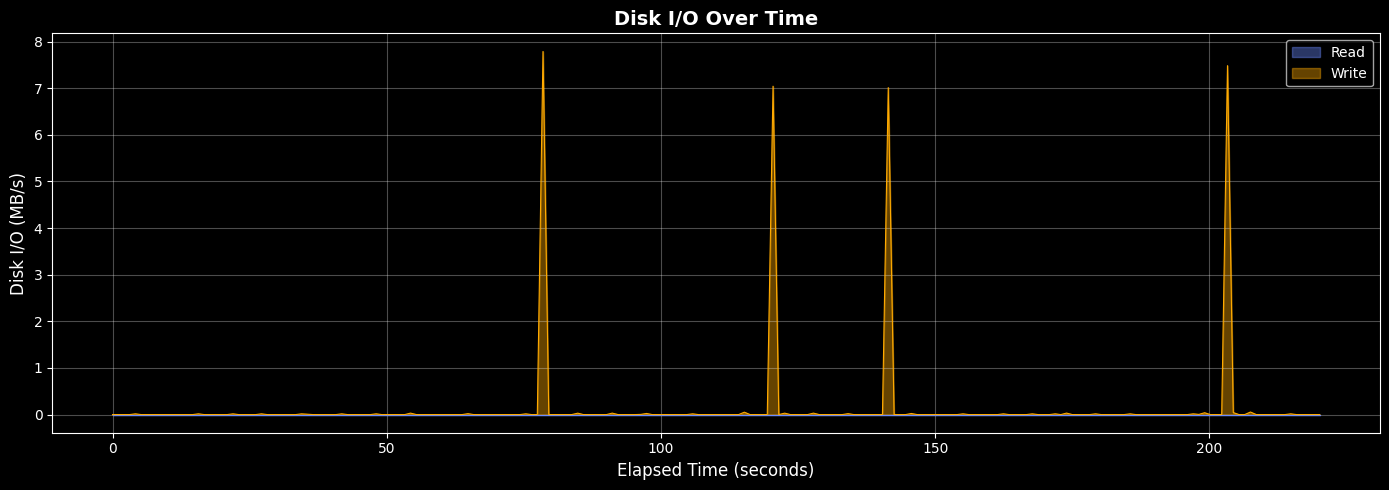


💿 Disk I/O Analysis:
   Total Read: 0.00 MB
   Total Written: 30.13 MB


In [8]:
fig, ax = plt.subplots(figsize=(14, 5))

ax.fill_between(samples['elapsed_seconds'], samples['diskread_rate'], alpha=0.4, color='#6b8aff', label='Read')
ax.fill_between(samples['elapsed_seconds'], samples['diskwrite_rate'], alpha=0.4, color='#ffaa00', label='Write')
ax.plot(samples['elapsed_seconds'], samples['diskread_rate'], color='#6b8aff', linewidth=0.8)
ax.plot(samples['elapsed_seconds'], samples['diskwrite_rate'], color='#ffaa00', linewidth=0.8)

ax.set_ylabel('Disk I/O (MB/s)', fontsize=12)
ax.set_xlabel('Elapsed Time (seconds)', fontsize=12)
ax.set_title('Disk I/O Over Time', fontsize=14, fontweight='bold')
ax.legend(loc='upper right')
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\n💿 Disk I/O Analysis:")
print(f"   Total Read: {data['disk_io']['mb_read']:.2f} MB")
print(f"   Total Written: {data['disk_io']['mb_written']:.2f} MB")

## Combined Overview Dashboard

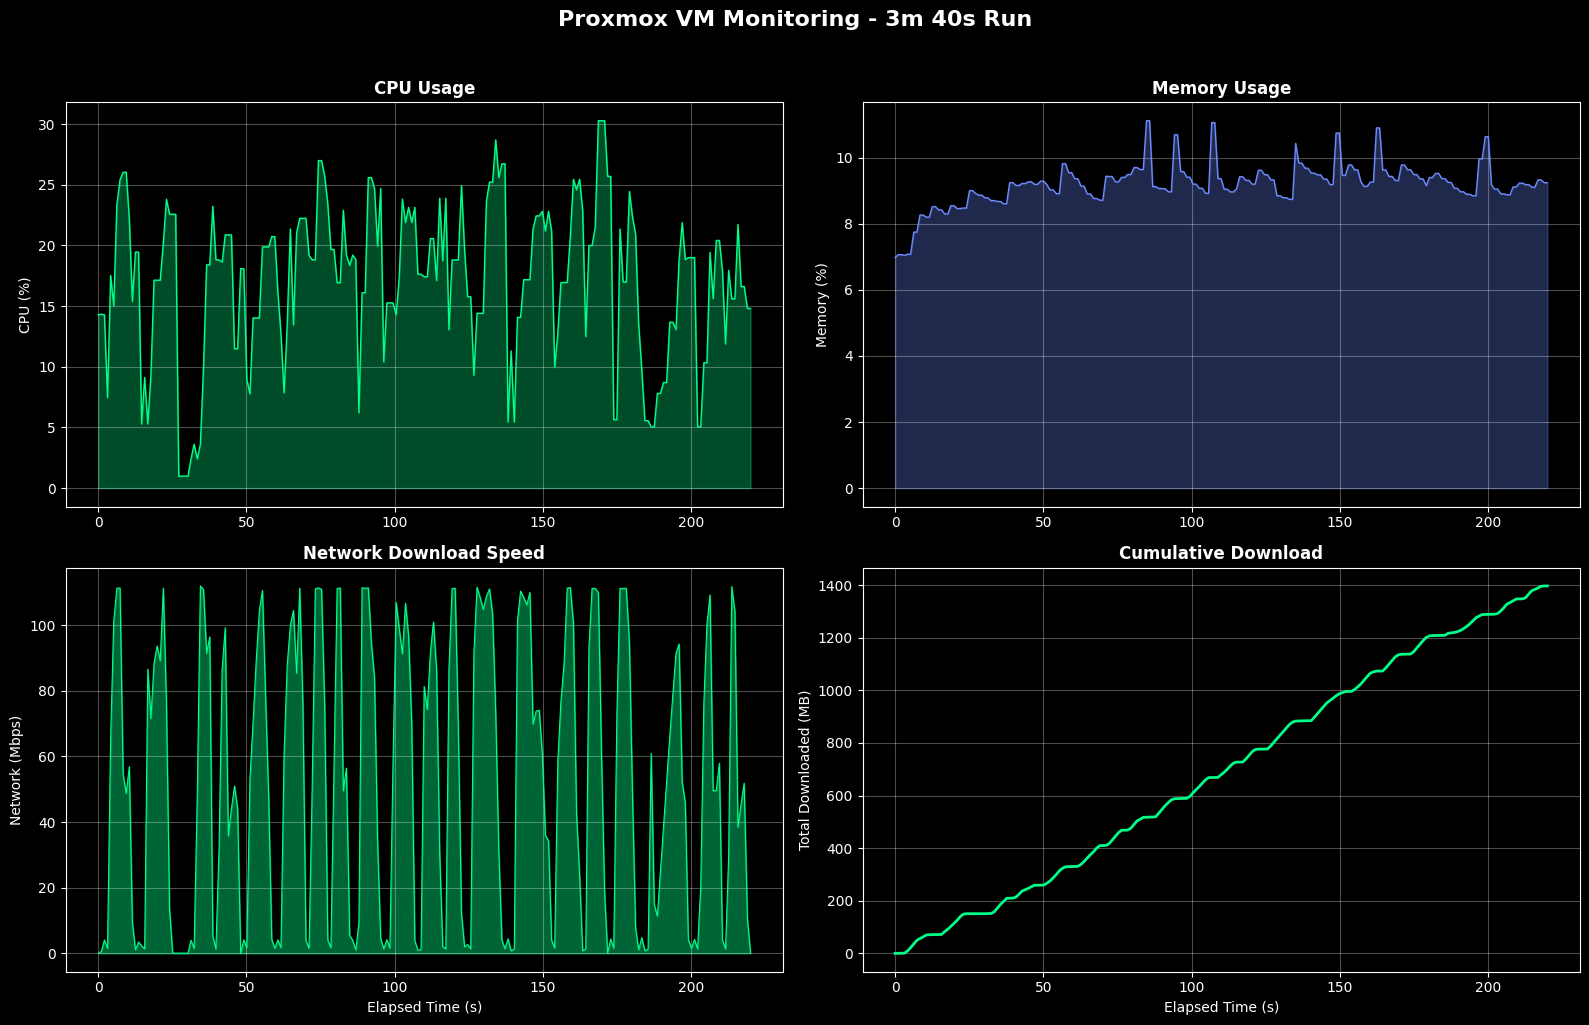

In [ ]:
fig, axes = plt.subplots(2, 2, figsize=(16, 10))

# CPU
ax1 = axes[0, 0]
ax1.fill_between(samples['elapsed_seconds'], samples['cpu_percent'], alpha=0.3, color='#00ff88')
ax1.plot(samples['elapsed_seconds'], samples['cpu_percent'], color='#00ff88', linewidth=1)
ax1.set_ylabel('CPU (%)')
ax1.set_title('CPU Usage', fontweight='bold')
ax1.grid(True, alpha=0.3)

# Memory in GB
ax2 = axes[0, 1]
ax2.fill_between(samples['elapsed_seconds'], samples['mem_gb'], alpha=0.3, color='#6b8aff')
ax2.plot(samples['elapsed_seconds'], samples['mem_gb'], color='#6b8aff', linewidth=1)
ax2.axhline(y=data['memory_stats']['total_gb'], color='#ffaa00', linestyle=':', alpha=0.5)
ax2.set_ylabel('Memory (GB)')
ax2.set_title(f"Memory Usage (Total: {data['memory_stats']['total_gb']:.1f} GB)", fontweight='bold')
ax2.grid(True, alpha=0.3)

# Network
ax3 = axes[1, 0]
ax3.fill_between(samples['elapsed_seconds'], samples['netin_mbps'], alpha=0.4, color='#00ff88', label='Download')
ax3.plot(samples['elapsed_seconds'], samples['netin_mbps'], color='#00ff88', linewidth=0.8)
ax3.set_ylabel('Network (Mbps)')
ax3.set_xlabel('Elapsed Time (s)')
ax3.set_title('Network Download Speed', fontweight='bold')
ax3.grid(True, alpha=0.3)

# Cumulative Transfer
ax4 = axes[1, 1]
ax4.plot(samples['elapsed_seconds'], samples['cumulative_in_mb'], color='#00ff88', linewidth=2)
ax4.set_ylabel('Total Downloaded (MB)')
ax4.set_xlabel('Elapsed Time (s)')
ax4.set_title('Cumulative Download', fontweight='bold')
ax4.grid(True, alpha=0.3)

plt.suptitle(f"Proxmox VM Monitoring - {data['monitoring_period']['duration_formatted']} Run", 
             fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

## Bottleneck Analysis

Analyze what's limiting performance based on the metrics.

In [ ]:
print("=" * 60)
print("BOTTLENECK ANALYSIS")
print("=" * 60)

# Analyze utilization
avg_cpu = data['cpu_stats']['avg_percent']
avg_mem_gb = data['memory_stats']['avg_gb']
total_mem_gb = data['memory_stats']['total_gb']
avg_net = data['network_transfer']['avg_speed_mbps_in']
total_mb = data['network_transfer']['mb_in']
duration = data['monitoring_period']['duration_seconds']

print(f"\n🔍 Resource Utilization:")
print(f"   CPU: {avg_cpu:.1f}% avg (max {data['cpu_stats']['max_percent']:.1f}%)")
print(f"   Memory: {avg_mem_gb:.2f} GB avg / {total_mem_gb:.1f} GB total (max {data['memory_stats']['max_gb']:.2f} GB)")
print(f"   Network: {avg_net:.1f} Mbps avg")

# Determine bottleneck
print(f"\n🎯 Likely Bottleneck:")
if avg_cpu > 70:
    print("   → CPU-bound: High CPU utilization suggests processing is the bottleneck")
elif avg_net < 10 and total_mb > 100:
    print("   → Network latency-bound: Low throughput despite significant data transfer")
    print("     Consider: Parallel fetching, larger grid cells, or caching")
elif avg_cpu < 30 and avg_net > 50:
    print("   → Well-balanced: Good network utilization with low CPU")
else:
    print("   → Network I/O-bound: Waiting for data from remote servers")
    print("     The algorithm spends most time waiting for network responses.")

# Calculate efficiency metrics
print(f"\n📊 Efficiency Metrics:")
print(f"   Data throughput: {total_mb / duration:.2f} MB/s")
print(f"   Processing rate: {total_mb / avg_cpu:.2f} MB per CPU%")

# Time breakdown estimate
idle_samples = len(samples[samples['cpu_percent'] < 5])
active_samples = len(samples[samples['cpu_percent'] >= 5])
idle_pct = 100 * idle_samples / len(samples)
print(f"\n⏱️ Time Breakdown (estimated):")
print(f"   Active processing: {100 - idle_pct:.1f}% of time")
print(f"   Idle (waiting for I/O): {idle_pct:.1f}% of time")

BOTTLENECK ANALYSIS

🔍 Resource Utilization:
   CPU: 17.2% avg (max 30.3%)
   Memory: 9.2% avg (max 11.1%)
   Network: 53.2 Mbps avg

🎯 Likely Bottleneck:
   → Well-balanced: Good network utilization with low CPU

📊 Efficiency Metrics:
   Data throughput: 6.34 MB/s
   Processing rate: 81.42 MB per CPU%

⏱️ Time Breakdown (estimated):
   Active processing: 96.2% of time
   Idle (waiting for I/O): 3.8% of time


## Network Activity Periods

Identify periods of high vs low network activity to understand fetch patterns.

In [11]:
# Identify high activity periods (above 50% of max)
threshold = samples['netin_mbps'].max() * 0.3
samples['high_activity'] = samples['netin_mbps'] > threshold

# Find transitions
samples['activity_change'] = samples['high_activity'].diff().fillna(False)

# Count bursts
burst_starts = samples[samples['activity_change'] & samples['high_activity']]
print(f"Detected {len(burst_starts)} network activity bursts")
print(f"Threshold for 'high activity': {threshold:.1f} Mbps")

# Time in high vs low activity
high_activity_time = samples['high_activity'].sum()  # seconds (1 sample ≈ 1 second)
total_time = len(samples)
print(f"\nTime in high network activity: {high_activity_time}s ({100*high_activity_time/total_time:.1f}%)")
print(f"Time in low network activity: {total_time - high_activity_time}s ({100*(total_time-high_activity_time)/total_time:.1f}%)")

Detected 21 network activity bursts
Threshold for 'high activity': 33.6 Mbps

Time in high network activity: 128s (60.7%)
Time in low network activity: 83s (39.3%)


C:\Users\justi\AppData\Local\Temp\ipykernel_18812\3164163147.py:6: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  samples['activity_change'] = samples['high_activity'].diff().fillna(False)


---

# Multi-Test Comparison

Compare all test runs from the output folder to identify performance differences across configurations.

In [ ]:
import os
from pathlib import Path
import glob

OUTPUT_DIR = Path('output')

def load_test_runs(output_dir):
    """Load all test runs from the output directory."""
    test_runs = []
    
    for test_folder in sorted(output_dir.iterdir()):
        if not test_folder.is_dir():
            continue
            
        run_data = {
            'name': test_folder.name,
            'path': test_folder,
            'statistics': None,
            'monitoring': None,
            'grid': None
        }
        
        # Find statistics file
        stats_files = list(test_folder.glob('statistics_*.json'))
        if stats_files:
            with open(stats_files[0], 'r') as f:
                run_data['statistics'] = json.load(f)
                run_data['stats_file'] = stats_files[0].name
        
        # Find proxmox monitoring file
        monitoring_files = list(test_folder.glob('proxmox_monitoring_*.json'))
        if monitoring_files:
            with open(monitoring_files[0], 'r') as f:
                run_data['monitoring'] = json.load(f)
                run_data['monitoring_file'] = monitoring_files[0].name
        
        # Find grid file
        grid_files = list(test_folder.glob('processed_grid_*.geojson'))
        if grid_files:
            run_data['grid_file'] = grid_files[0].name
        
        # Count NDSI tiles
        ndsi_folder = test_folder / 'ndsi_tiles'
        if ndsi_folder.exists():
            run_data['tile_count'] = len(list(ndsi_folder.glob('*.tif')))
        else:
            run_data['tile_count'] = 0
        
        test_runs.append(run_data)
    
    return test_runs

# Load all test runs
test_runs = load_test_runs(OUTPUT_DIR)
print(f"Found {len(test_runs)} test runs in '{OUTPUT_DIR}':\n")

for run in test_runs:
    print(f"📁 {run['name']}")
    print(f"   Statistics: {'✅' if run['statistics'] else '❌'}")
    print(f"   Monitoring: {'✅' if run['monitoring'] else '❌'}")
    print(f"   NDSI Tiles: {run['tile_count']}")
    print()

## Test Configuration Comparison

Compare the configurations and results across all test runs.

In [ ]:
# Build comparison table for runs with statistics
runs_with_stats = [r for r in test_runs if r['statistics']]

if runs_with_stats:
    comparison_data = []
    for run in runs_with_stats:
        stats = run['statistics']
        config = stats.get('configuration', {})
        results = stats.get('results', {})
        
        comparison_data.append({
            'Test Name': run['name'],
            'Grid Size (m)': config.get('grid_size', 'N/A'),
            'Max Iterations': config.get('max_iterations', 'N/A'),
            'Date Range': f"{config.get('date_start', '?')} - {config.get('date_end', '?')}",
            'Cells Processed': results.get('total_cells_processed', 'N/A'),
            'Snow/Ice km²': round(results.get('snow_ice_coverage_km2', 0), 2),
            'Processing Time': results.get('processing_time_formatted', 'N/A'),
            'Time (s)': round(results.get('processing_time_seconds', 0), 1),
            'Low Memory': config.get('low_memory', False)
        })
    
    comparison_df = pd.DataFrame(comparison_data)
    print("=" * 80)
    print("CONFIGURATION & RESULTS COMPARISON")
    print("=" * 80)
    display(comparison_df)
else:
    print("No test runs with statistics found.")

## Performance Metrics Comparison

Compare resource usage across test runs with monitoring data.

In [ ]:
# Compare monitoring data across runs
runs_with_monitoring = [r for r in test_runs if r['monitoring']]

if runs_with_monitoring:
    monitoring_data = []
    for run in runs_with_monitoring:
        mon = run['monitoring']
        samples_df = pd.DataFrame(mon['samples'])
        
        # Calculate memory in GB
        mem_min_gb = samples_df['mem'].min() / (1024**3)
        mem_max_gb = samples_df['mem'].max() / (1024**3)
        mem_avg_gb = samples_df['mem'].mean() / (1024**3)
        total_mem_gb = samples_df['maxmem'].iloc[0] / (1024**3)
        
        monitoring_data.append({
            'Test Name': run['name'],
            'Duration': mon['monitoring_period']['duration_formatted'],
            'Samples': mon['samples_collected'],
            'Avg CPU %': round(mon['cpu_stats']['avg_percent'], 1),
            'Max CPU %': round(mon['cpu_stats']['max_percent'], 1),
            'Avg Mem GB': round(mem_avg_gb, 2),
            'Max Mem GB': round(mem_max_gb, 2),
            'Total Mem GB': round(total_mem_gb, 1),
            'Downloaded MB': round(mon['network_transfer']['mb_in'], 1),
            'Avg DL Mbps': round(mon['network_transfer']['avg_speed_mbps_in'], 1),
            'Disk Read MB': round(mon['disk_io']['mb_read'], 1),
            'Disk Write MB': round(mon['disk_io']['mb_written'], 1)
        })
    
    monitoring_df = pd.DataFrame(monitoring_data)
    print("=" * 80)
    print("PERFORMANCE METRICS COMPARISON")
    print("=" * 80)
    display(monitoring_df)
else:
    print("No test runs with monitoring data found.")
    print("Monitoring files should be named 'proxmox_monitoring_*.json'")

## Processing Time Comparison

In [ ]:
if runs_with_stats:
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # Processing time bar chart
    names = [r['name'] for r in runs_with_stats]
    times = [r['statistics']['results'].get('processing_time_seconds', 0) for r in runs_with_stats]
    cells = [r['statistics']['results'].get('total_cells_processed', 0) for r in runs_with_stats]
    
    colors = plt.cm.viridis(np.linspace(0.2, 0.8, len(names)))
    
    ax1 = axes[0]
    bars = ax1.bar(names, times, color=colors, edgecolor='white', linewidth=1.5)
    ax1.set_ylabel('Processing Time (seconds)', fontsize=12)
    ax1.set_xlabel('Test Run', fontsize=12)
    ax1.set_title('Processing Time per Test', fontsize=14, fontweight='bold')
    ax1.tick_params(axis='x', rotation=45)
    ax1.grid(True, alpha=0.3, axis='y')
    
    # Add time labels on bars
    for bar, time in zip(bars, times):
        minutes = int(time // 60)
        seconds = int(time % 60)
        ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 5, 
                f'{minutes}m {seconds}s', ha='center', va='bottom', fontsize=10)
    
    # Cells processed bar chart
    ax2 = axes[1]
    bars2 = ax2.bar(names, cells, color=colors, edgecolor='white', linewidth=1.5)
    ax2.set_ylabel('Cells Processed', fontsize=12)
    ax2.set_xlabel('Test Run', fontsize=12)
    ax2.set_title('Cells Processed per Test', fontsize=14, fontweight='bold')
    ax2.tick_params(axis='x', rotation=45)
    ax2.grid(True, alpha=0.3, axis='y')
    
    # Add count labels on bars
    for bar, count in zip(bars2, cells):
        ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5, 
                str(count), ha='center', va='bottom', fontsize=10)
    
    plt.tight_layout()
    plt.show()
else:
    print("No statistics data available for comparison.")

## Resource Usage Comparison

Compare CPU, Memory, and Network usage across all test runs with monitoring data.

In [ ]:
if runs_with_monitoring:
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    
    names = [r['name'] for r in runs_with_monitoring]
    colors = plt.cm.viridis(np.linspace(0.2, 0.8, len(names)))
    
    # CPU Usage comparison
    ax1 = axes[0, 0]
    avg_cpu = [r['monitoring']['cpu_stats']['avg_percent'] for r in runs_with_monitoring]
    max_cpu = [r['monitoring']['cpu_stats']['max_percent'] for r in runs_with_monitoring]
    x = np.arange(len(names))
    width = 0.35
    ax1.bar(x - width/2, avg_cpu, width, label='Average', color='#00ff88', alpha=0.8)
    ax1.bar(x + width/2, max_cpu, width, label='Maximum', color='#ff6b6b', alpha=0.8)
    ax1.set_ylabel('CPU Usage (%)')
    ax1.set_title('CPU Usage Comparison', fontweight='bold')
    ax1.set_xticks(x)
    ax1.set_xticklabels(names, rotation=45, ha='right')
    ax1.legend()
    ax1.grid(True, alpha=0.3, axis='y')
    
    # Memory Usage comparison in GB
    ax2 = axes[0, 1]
    avg_mem_gb = [pd.DataFrame(r['monitoring']['samples'])['mem'].mean() / (1024**3) for r in runs_with_monitoring]
    max_mem_gb = [pd.DataFrame(r['monitoring']['samples'])['mem'].max() / (1024**3) for r in runs_with_monitoring]
    ax2.bar(x - width/2, avg_mem_gb, width, label='Average', color='#6b8aff', alpha=0.8)
    ax2.bar(x + width/2, max_mem_gb, width, label='Maximum', color='#ffaa00', alpha=0.8)
    ax2.set_ylabel('Memory Usage (GB)')
    ax2.set_title('Memory Usage Comparison', fontweight='bold')
    ax2.set_xticks(x)
    ax2.set_xticklabels(names, rotation=45, ha='right')
    ax2.legend()
    ax2.grid(True, alpha=0.3, axis='y')
    
    # Network Download comparison
    ax3 = axes[1, 0]
    downloaded = [r['monitoring']['network_transfer']['mb_in'] for r in runs_with_monitoring]
    ax3.bar(names, downloaded, color=colors, edgecolor='white', linewidth=1.5)
    ax3.set_ylabel('Downloaded (MB)')
    ax3.set_title('Total Network Download', fontweight='bold')
    ax3.tick_params(axis='x', rotation=45)
    ax3.grid(True, alpha=0.3, axis='y')
    
    # Average Network Speed comparison
    ax4 = axes[1, 1]
    avg_speed = [r['monitoring']['network_transfer']['avg_speed_mbps_in'] for r in runs_with_monitoring]
    ax4.bar(names, avg_speed, color=colors, edgecolor='white', linewidth=1.5)
    ax4.set_ylabel('Average Speed (Mbps)')
    ax4.set_title('Average Download Speed', fontweight='bold')
    ax4.tick_params(axis='x', rotation=45)
    ax4.grid(True, alpha=0.3, axis='y')
    
    plt.suptitle('Resource Usage Across Test Runs', fontsize=16, fontweight='bold', y=1.02)
    plt.tight_layout()
    plt.show()
else:
    print("No monitoring data available for comparison.")

## Efficiency Metrics

Compare processing efficiency (cells per minute, MB per cell, etc.)

In [ ]:
# Calculate efficiency metrics for runs with both statistics and monitoring
runs_with_both = [r for r in test_runs if r['statistics'] and r['monitoring']]

if runs_with_both:
    efficiency_data = []
    for run in runs_with_both:
        stats = run['statistics']
        mon = run['monitoring']
        
        cells = stats['results'].get('total_cells_processed', 0)
        time_sec = stats['results'].get('processing_time_seconds', 1)
        downloaded_mb = mon['network_transfer']['mb_in']
        coverage_km2 = stats['results'].get('snow_ice_coverage_km2', 0)
        
        efficiency_data.append({
            'Test Name': run['name'],
            'Cells/Minute': round(cells / (time_sec / 60), 2) if time_sec > 0 else 0,
            'Sec/Cell': round(time_sec / cells, 2) if cells > 0 else 0,
            'MB/Cell': round(downloaded_mb / cells, 2) if cells > 0 else 0,
            'MB Downloaded': round(downloaded_mb, 1),
            'km²/Minute': round(coverage_km2 / (time_sec / 60), 3) if time_sec > 0 else 0,
            'Data Efficiency (km²/MB)': round(coverage_km2 / downloaded_mb, 4) if downloaded_mb > 0 else 0
        })
    
    efficiency_df = pd.DataFrame(efficiency_data)
    print("=" * 80)
    print("EFFICIENCY METRICS")
    print("=" * 80)
    display(efficiency_df)
    
    # Visualize efficiency
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    
    names = [d['Test Name'] for d in efficiency_data]
    colors = plt.cm.plasma(np.linspace(0.2, 0.8, len(names)))
    
    # Cells per minute
    ax1 = axes[0]
    cells_per_min = [d['Cells/Minute'] for d in efficiency_data]
    ax1.bar(names, cells_per_min, color=colors, edgecolor='white', linewidth=1.5)
    ax1.set_ylabel('Cells per Minute')
    ax1.set_title('Processing Speed', fontweight='bold')
    ax1.tick_params(axis='x', rotation=45)
    ax1.grid(True, alpha=0.3, axis='y')
    
    # MB per cell
    ax2 = axes[1]
    mb_per_cell = [d['MB/Cell'] for d in efficiency_data]
    ax2.bar(names, mb_per_cell, color=colors, edgecolor='white', linewidth=1.5)
    ax2.set_ylabel('MB per Cell')
    ax2.set_title('Data Usage per Cell', fontweight='bold')
    ax2.tick_params(axis='x', rotation=45)
    ax2.grid(True, alpha=0.3, axis='y')
    
    # Coverage efficiency
    ax3 = axes[2]
    km2_per_min = [d['km²/Minute'] for d in efficiency_data]
    ax3.bar(names, km2_per_min, color=colors, edgecolor='white', linewidth=1.5)
    ax3.set_ylabel('km² per Minute')
    ax3.set_title('Coverage Speed', fontweight='bold')
    ax3.tick_params(axis='x', rotation=45)
    ax3.grid(True, alpha=0.3, axis='y')
    
    plt.suptitle('Processing Efficiency Comparison', fontsize=14, fontweight='bold', y=1.02)
    plt.tight_layout()
    plt.show()
else:
    print("No test runs with both statistics and monitoring data found.")

## Timeline Comparison

Compare resource usage over time across all test runs with monitoring data.

In [ ]:
if runs_with_monitoring:
    fig, axes = plt.subplots(2, 2, figsize=(16, 10))
    
    # Color palette for different runs
    colors = plt.cm.tab10(np.linspace(0, 1, len(runs_with_monitoring)))
    
    for idx, run in enumerate(runs_with_monitoring):
        mon = run['monitoring']
        samples_df = pd.DataFrame(mon['samples'])
        samples_df['elapsed_seconds'] = samples_df['time'] - samples_df['time'].iloc[0]
        
        # Calculate memory in GB
        samples_df['mem_gb'] = samples_df['mem'] / (1024**3)
        
        # Calculate rates
        samples_df['netin_rate'] = samples_df['netin'].diff() / samples_df['time'].diff()
        samples_df['netin_mbps'] = samples_df['netin_rate'] * 8 / 1e6
        samples_df['cumulative_in_mb'] = (samples_df['netin'] - samples_df['netin'].iloc[0]) / (1024 * 1024)
        samples_df = samples_df.fillna(0)
        
        # Normalize time to percentage for comparison
        max_time = samples_df['elapsed_seconds'].max()
        samples_df['time_pct'] = 100 * samples_df['elapsed_seconds'] / max_time if max_time > 0 else 0
        
        label = run['name']
        color = colors[idx]
        
        # CPU over time
        axes[0, 0].plot(samples_df['time_pct'], samples_df['cpu_percent'], 
                       label=label, color=color, linewidth=1.5, alpha=0.8)
        
        # Memory over time in GB
        axes[0, 1].plot(samples_df['time_pct'], samples_df['mem_gb'], 
                       label=label, color=color, linewidth=1.5, alpha=0.8)
        
        # Network speed over time
        axes[1, 0].plot(samples_df['time_pct'], samples_df['netin_mbps'], 
                       label=label, color=color, linewidth=1, alpha=0.7)
        
        # Cumulative download over time (normalized)
        max_download = samples_df['cumulative_in_mb'].max()
        samples_df['download_pct'] = 100 * samples_df['cumulative_in_mb'] / max_download if max_download > 0 else 0
        axes[1, 1].plot(samples_df['time_pct'], samples_df['download_pct'], 
                       label=label, color=color, linewidth=2, alpha=0.8)
    
    # Style the plots
    axes[0, 0].set_ylabel('CPU Usage (%)')
    axes[0, 0].set_title('CPU Usage Over Time', fontweight='bold')
    axes[0, 0].legend(loc='upper right', fontsize=8)
    axes[0, 0].grid(True, alpha=0.3)
    axes[0, 0].set_xlabel('Progress (%)')
    
    axes[0, 1].set_ylabel('Memory Usage (GB)')
    axes[0, 1].set_title('Memory Usage Over Time', fontweight='bold')
    axes[0, 1].legend(loc='upper right', fontsize=8)
    axes[0, 1].grid(True, alpha=0.3)
    axes[0, 1].set_xlabel('Progress (%)')
    
    axes[1, 0].set_ylabel('Network Speed (Mbps)')
    axes[1, 0].set_title('Network Download Speed', fontweight='bold')
    axes[1, 0].legend(loc='upper right', fontsize=8)
    axes[1, 0].grid(True, alpha=0.3)
    axes[1, 0].set_xlabel('Progress (%)')
    
    axes[1, 1].set_ylabel('Download Progress (%)')
    axes[1, 1].set_title('Cumulative Download (Normalized)', fontweight='bold')
    axes[1, 1].legend(loc='upper left', fontsize=8)
    axes[1, 1].grid(True, alpha=0.3)
    axes[1, 1].set_xlabel('Progress (%)')
    
    plt.suptitle('Resource Usage Timeline Comparison (Normalized)', fontsize=16, fontweight='bold', y=1.02)
    plt.tight_layout()
    plt.show()
else:
    print("No monitoring data available for timeline comparison.")

## Summary Report

Generate a comprehensive summary comparing all test runs.

In [ ]:
print("=" * 80)
print("MULTI-TEST COMPARISON SUMMARY")
print("=" * 80)

if runs_with_both:
    print(f"\n📊 Analyzed {len(runs_with_both)} test runs with full data:")
    
    # Find best performers
    best_speed = max(runs_with_both, key=lambda r: r['statistics']['results'].get('total_cells_processed', 0) / 
                     max(r['statistics']['results'].get('processing_time_seconds', 1), 1))
    best_coverage = max(runs_with_both, key=lambda r: r['statistics']['results'].get('snow_ice_coverage_km2', 0))
    lowest_cpu = min(runs_with_both, key=lambda r: r['monitoring']['cpu_stats']['avg_percent'])
    highest_throughput = max(runs_with_both, key=lambda r: r['monitoring']['network_transfer']['avg_speed_mbps_in'])
    
    print(f"\n🏆 Best Performers:")
    print(f"   Fastest processing: {best_speed['name']}")
    cells = best_speed['statistics']['results'].get('total_cells_processed', 0)
    time = best_speed['statistics']['results'].get('processing_time_seconds', 1)
    print(f"      ({cells} cells in {time:.0f}s = {cells/(time/60):.1f} cells/min)")
    
    print(f"   Largest coverage: {best_coverage['name']}")
    print(f"      ({best_coverage['statistics']['results'].get('snow_ice_coverage_km2', 0):.2f} km²)")
    
    print(f"   Lowest CPU usage: {lowest_cpu['name']}")
    print(f"      ({lowest_cpu['monitoring']['cpu_stats']['avg_percent']:.1f}% avg)")
    
    print(f"   Highest network throughput: {highest_throughput['name']}")
    print(f"      ({highest_throughput['monitoring']['network_transfer']['avg_speed_mbps_in']:.1f} Mbps avg)")
    
    # Overall statistics
    total_cells = sum(r['statistics']['results'].get('total_cells_processed', 0) for r in runs_with_both)
    total_time = sum(r['statistics']['results'].get('processing_time_seconds', 0) for r in runs_with_both)
    total_downloaded = sum(r['monitoring']['network_transfer']['mb_in'] for r in runs_with_both)
    total_coverage = sum(r['statistics']['results'].get('snow_ice_coverage_km2', 0) for r in runs_with_both)
    
    print(f"\n📈 Totals Across All Runs:")
    print(f"   Total cells processed: {total_cells}")
    print(f"   Total processing time: {total_time/60:.1f} minutes")
    print(f"   Total data downloaded: {total_downloaded:.1f} MB ({total_downloaded/1024:.2f} GB)")
    print(f"   Total coverage analyzed: {total_coverage:.2f} km²")
    
elif runs_with_stats:
    print(f"\n📊 Analyzed {len(runs_with_stats)} test runs (statistics only):")
    for run in runs_with_stats:
        stats = run['statistics']
        print(f"\n   {run['name']}:")
        print(f"      Cells: {stats['results'].get('total_cells_processed', 'N/A')}")
        print(f"      Coverage: {stats['results'].get('snow_ice_coverage_km2', 0):.2f} km²")
        print(f"      Time: {stats['results'].get('processing_time_formatted', 'N/A')}")
else:
    print("\n⚠️ No test runs with statistics found in the output folder.")
    print("   Make sure your test runs save statistics_*.json files.")

print("\n" + "=" * 80)